# The Office 
##### Analysis of Jim & Dwight's relationship 

**Question:** How and/or if Dwight and Jim's sentiments throughout the show were related - as rivals, was one more positive when the other was negative?

In [1]:
# Import necessary libraries 

import pandas as pd
import numpy as np
import re
import IPython.display
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from IPython.display import display



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# Import dataset and take a look at the format

# Source: Reddit, https://www.reddit.com/r/datasets/comments/6yt3og/every_line_from_every_episode_of_the_office_us/

url = 'https://raw.githubusercontent.com/clairemasse/theoffice/master/theofficelines.csv'
theoffice = pd.read_csv(url, index_col='id')
display(theoffice.head())

,season,episode,scene,line_text,speaker,deleted
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


In [0]:
# Drop deleted scenes
deletedscenes = (theoffice['deleted'] == True)
theoffice.drop(index=theoffice[deletedscenes].index, inplace=True)
theoffice.drop(['deleted'], axis=1, inplace=True)


In [4]:
# Fix incorrectly formatted apostrophes in line_text column
lines = theoffice['line_text']
lines = lines.str.replace('���', "'")

theoffice['line_text'] = lines

# Check
print('� in lines?:','���' in lines)



� in lines?: False


In [5]:
# Initial look at data by speaker/character
speaker_col = theoffice['speaker']
characters = pd.DataFrame(speaker_col.value_counts())
characters.reset_index(inplace=True)
characters.rename(columns={'index': 'speaker',
                           'speaker': 'num_lines'}, inplace=True)


# We only want to look at main characters -- drop speakers with fewer than 600 lines throughout the whole series
fewlines = characters.loc[:, 'num_lines'] < 600
characters.drop(index=characters[fewlines].index, inplace=True)
display(characters.head())

,speaker,num_lines
0,Michael,11574
1,Dwight,7167
2,Jim,6609
3,Pam,5205
4,Andy,3969


In [0]:
# Drop rows from original dataframe to match those we dropped in speakers df
keepspeakers = ~theoffice['speaker'].isin(characters['speaker'])
theoffice.drop(index=theoffice[keepspeakers].index, inplace=True)



In [7]:
# Add a column to the dataframe with number of words in each line
def numwords(line):
    return len(line.split(" "))


theoffice['length'] = theoffice['line_text'].apply(numwords)
display(theoffice.head())

,season,episode,scene,line_text,speaker,length
id,,,,,,
1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,14
2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,9
3,1,1,1,So you've come to the master for guidance? Is ...,Michael,14
4,1,1,1,"Actually, you called me in here, but yeah.",Jim,8
5,1,1,1,"All right. Well, let me show you how it's done.",Michael,10


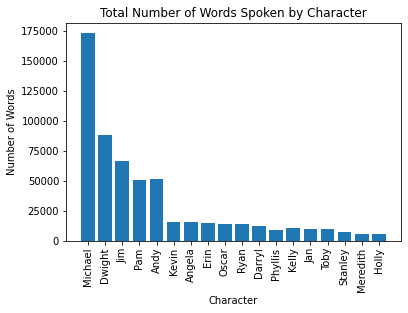

In [8]:
# Let's see how many words each character spoke
listcharacters = characters['speaker'].tolist()


def totalwords(character):
    rows = (theoffice.loc[theoffice['speaker'] == character, 'length'])
    totalwords = rows.sum()
    return totalwords


characterwords = []
for character in listcharacters:
    characterwords.append(totalwords(character))


y_pos = np.arange(len(listcharacters))
plt.bar(y_pos, characterwords)
plt.xlabel('Character')
plt.xticks(y_pos, listcharacters, rotation='vertical')
plt.ylabel('Number of Words')
plt.title('Total Number of Words Spoken by Character')
plt.show()


I decided to use NLTK Sentiment Analysis library's VADER model for a number of reasons, but mainly given how easy it is to use as this is my first attempt at sentiment analysis. 

It doesn't require any training data but is constructed from a generalizable, human-curated standard sentiment lexicon. With one simple code, I was able to assign sentiment scores to all of the data at once.

The compound score I specifically use here is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most negative) and +1 (most positive). Along with analyzing how positive/negative the words used are, it also takes into account punctuation, capitalization, degree modifiers, conjuctions, and other key points to be considered when analyzing language. 

That being said, it works particularly well for social media texts, which is obviously not what I am dealing with here, so that's important to keep in mind when using these scores to draw conclusions.

More information here: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

In [9]:
# Sentiment Analysis
sid = SentimentIntensityAnalyzer()
lines = theoffice['line_text']


sentiments = []
for line in lines:
    ss = sid.polarity_scores(line)['compound']
    sentiments.append(ss)


theoffice['sentiment'] = sentiments
display(theoffice.tail())

,season,episode,scene,line_text,speaker,length,sentiment
id,,,,,,,
59904,9,23,111,"Everyday when I came into work, all I wanted t...",Darryl,27,-0.3108
59906,9,23,113,I just feel lucky that I got a chance to share...,Meredith,41,0.6298
59907,9,23,114,I'm happy that this was all filmed so I can re...,Phyllis,31,0.5719
59908,9,23,115,I sold paper at this company for 12 years. My ...,Jim,46,-0.5216
59909,9,23,116,I thought it was weird when you picked us to m...,Pam,46,0.8658


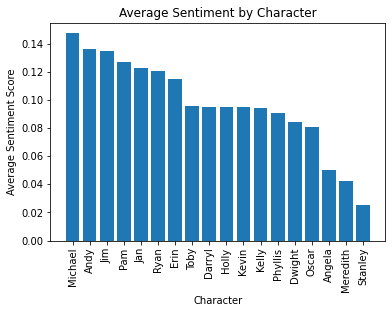

In [10]:
# Average sentiment per character

avgsent = theoffice.groupby('speaker')['sentiment'].mean().rename('Average Sentiment').reset_index()
avgsent = avgsent.sort_values(by='Average Sentiment', ascending=False)


listcharacters = avgsent['speaker'].tolist()
y_pos = np.arange(len(listcharacters))
length = avgsent['Average Sentiment'].tolist()


plt.bar(y_pos, length)
plt.xlabel('Character')
plt.ylabel('Average Sentiment Score')
plt.xticks(y_pos, listcharacters, rotation='vertical')
plt.title('Average Sentiment by Character')
plt.show()

Overall, Michael is the most positive character throughout the show throughout its entirety. 
And... to no one's surprise, Stanley is the most negative. 


Now that we've had a look at the data as a whole, let's look at only Jim and Dwight's lines to try and answer our question

In [0]:
# episode total number column

ep_total = []
i=0
while i in np.arange(0, len(theoffice),1):
  if theoffice.iloc[i, 0]==1:
    ep_total.append(theoffice.iloc[i, 1])
    i+=1
  elif theoffice.iloc[i, 1] < theoffice.iloc[i-1, 1]:
    ep_total.append(ep_total[-1] + 1)
    i+=1
  elif theoffice.iloc[i, 1] != theoffice.iloc[i-1, 1]:
    ep_total.append(ep_total[-1] + 1)
    i+=1
  else:
    ep_total.append(ep_total[-1])
    i += 1
  
theoffice['ep_total'] = pd.Series(ep_total, index=theoffice.index)


In [12]:
# New table just for Dwight and Jim
lite = theoffice.filter(['season', 'episode', 'scene', 'speaker', 'ep_total', 'sentiment'], axis=1)
dwightjim = lite[lite['speaker'].isin(['Dwight', 'Jim'])]
dwightjim['index'] = np.arange(0, len(dwightjim), 1)
dwightjim.set_index('index', inplace=True)
dwightjim.drop(dwightjim[dwightjim['ep_total']== 104].index, inplace=True)

display(dwightjim.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,season,episode,scene,speaker,ep_total,sentiment
index,,,,,,
0,1,1,1,Jim,1,0.0000
1,1,1,1,Jim,1,0.4215
2,1,1,5,Dwight,1,0.0516
3,1,1,6,Jim,1,-0.4019
4,1,1,7,Jim,1,0.6696


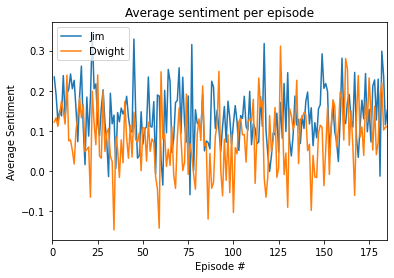

In [13]:
jim = dwightjim[dwightjim.speaker == 'Jim']
dwight = dwightjim[dwightjim.speaker == 'Dwight']

# avg sentiment per episode
ep_avgs_j = pd.DataFrame(jim.groupby(['ep_total','season'], as_index=False)['sentiment'].mean())

#jim did not appear in an episode - let's replace that empty value with his average over all episodes so that both series are the same length
ep_avgs_d = pd.DataFrame(dwight.groupby(['ep_total', 'season'], as_index=False)['sentiment'].mean())


# plot 
plt.plot(np.arange(1,186,1), ep_avgs_j['sentiment'], label='Jim')
plt.plot(np.arange(1,186,1), ep_avgs_d['sentiment'], label='Dwight')
plt.xlabel('Episode #')
plt.xlim(0, 185)
plt.ylabel('Average Sentiment')
plt.title('Average sentiment per episode')
plt.legend()
plt.show()


,ep_total,season,jim,dwight,difference
0,1,1,0.234192,0.121703,0.112488
1,2,1,0.189881,0.132305,0.057576
2,3,1,0.124543,0.111108,0.013435
3,4,1,0.150306,0.141969,0.008337
4,5,1,0.137145,0.174635,0.037489


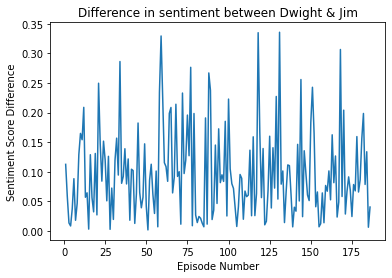

In [14]:
together = ep_avgs_j
together['dwight'] = ep_avgs_d['sentiment']
together.rename(columns={'sentiment':'jim'}, inplace=True)
together['difference'] = (together['jim']-together['dwight']).abs()


display(together.head())
plt.plot(together['ep_total'], together['difference'])
plt.xlabel('Episode Number')
plt.ylabel('Sentiment Score Difference')
plt.title('Difference in sentiment between Dwight & Jim')
plt.show()

#print(together['difference'].max(), 'index:', together['difference'].idxmax())


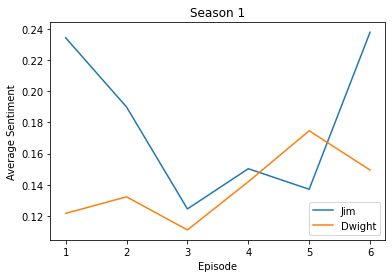

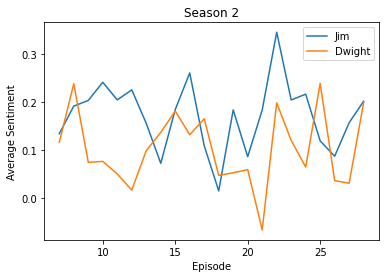

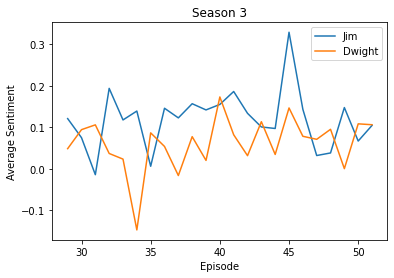

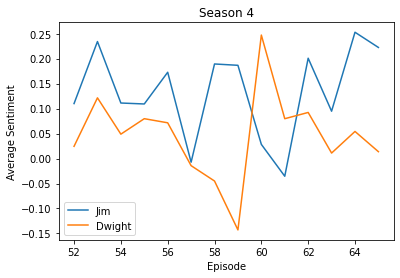

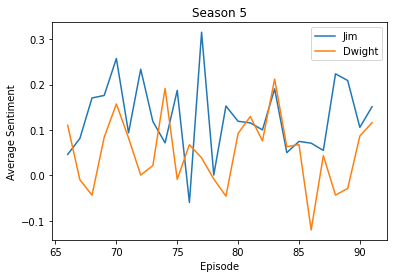

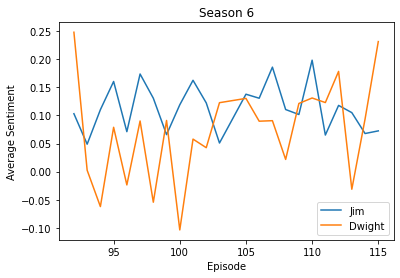

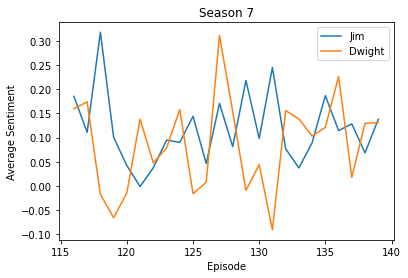

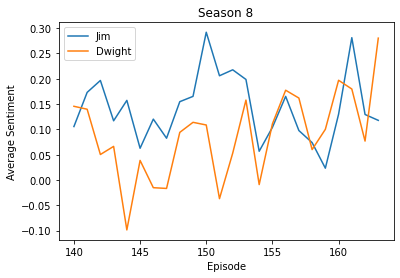

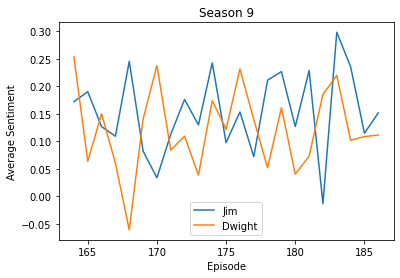

In [15]:
# Take a look at data by season


for i in np.arange(1,10):
  season = together.loc[together['season'] == i]
  plt.plot(season['ep_total'], season['jim'], label ='Jim')
  plt.plot(season['ep_total'], season['dwight'], label = 'Dwight')
  plt.xlabel('Episode')
  plt.ylabel('Average Sentiment')
  plt.title('Season %i' %i)
  plt.legend()
  plt.show()



In [16]:
print(together['jim'].corr(together['dwight']))

0.007912212503293003


no strong immediate correlation apparent - let's try and examine only scenes where both Dwight & jim appeared, eliminate some noise caused by their interactions with other characters

In [17]:

#scene total number column

sc_total = []
i=0
while i in np.arange(0, len(dwightjim),1):
  if dwightjim.iloc[i, 0]==1 and dwightjim.iloc[i, 1]==1 and dwightjim.iloc[i, 2]==1:
    sc_total.append(1)
    i+=1
  elif dwightjim.iloc[i, 2] < dwightjim.iloc[i-1, 2]:
    sc_total.append(sc_total[-1] + 1)
    i+=1
  elif dwightjim.iloc[i, 2] != dwightjim.iloc[i-1, 2]:
    sc_total.append(sc_total[-1] + 1)
    i+=1
  else:
    sc_total.append(sc_total[-1])
    i += 1
  
dwightjim['sc_total'] = pd.Series(sc_total, index=dwightjim.index)


display(dwightjim.head())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,season,episode,scene,speaker,ep_total,sentiment,sc_total
index,,,,,,,
0,1,1,1,Jim,1,0.0000,1
1,1,1,1,Jim,1,0.4215,1
2,1,1,5,Dwight,1,0.0516,2
3,1,1,6,Jim,1,-0.4019,3
4,1,1,7,Jim,1,0.6696,4


In [18]:
# group by scene and count unique instances in speaker col
byscene = pd.DataFrame(dwightjim.groupby('sc_total')['speaker'].nunique())
byscene.reset_index(inplace=True)

#if only 1 (aka only Jim or only Dwight are in that scene), drop

alone = byscene.loc[:,'speaker'] == 1
byscene.drop(index=byscene[alone].index, inplace=True)
display(byscene.head())

keepscenes = ~dwightjim['sc_total'].isin(byscene['sc_total'])
dwightjim.drop(index=dwightjim[keepscenes].index, inplace=True)



,sc_total,speaker
3,4,2
5,6,2
13,14,2
18,19,2
41,42,2


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
#avg sentiment by scene
jim2 = dwightjim[dwightjim.speaker == 'Jim']
dwight2 = dwightjim[dwightjim.speaker == 'Dwight']

sc_avgs_j = pd.DataFrame(jim2.groupby(['sc_total','season','episode'], as_index=False)['sentiment'].mean())
sc_avgs_d = pd.DataFrame(dwight2.groupby(['sc_total', 'season', 'episode'], as_index=False)['sentiment'].mean())


together2 = sc_avgs_j
together2['dwight'] = sc_avgs_d['sentiment']
together2.rename(columns={'sentiment':'jim'}, inplace=True)
together2['difference'] = (together2['jim']-together2['dwight'])


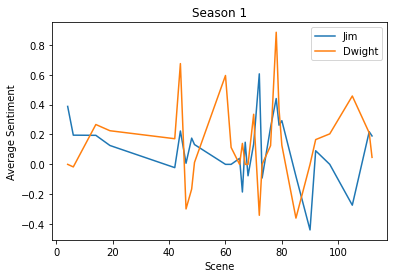

Correlation: 0.08048029418325747


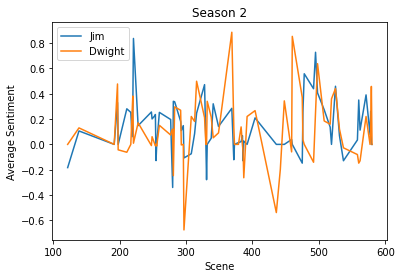

Correlation: 0.17162978009578608


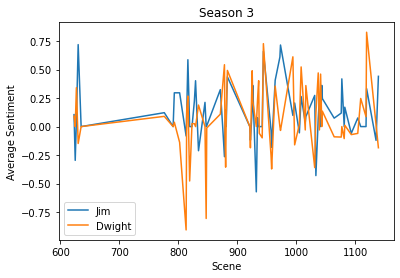

Correlation: 0.1641466011193663


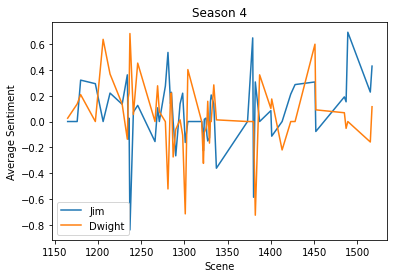

Correlation: -0.15102654685514622


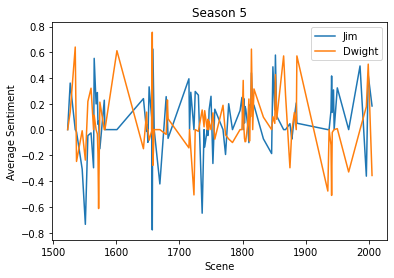

Correlation: -0.12312382273731838


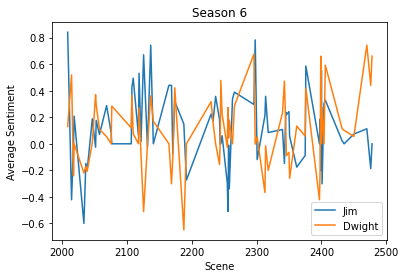

Correlation: -0.054830000234648374


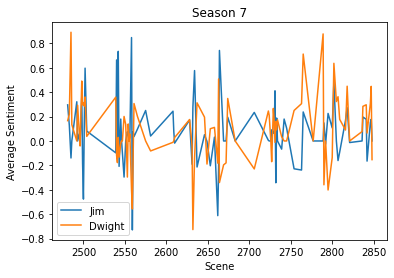

Correlation: -0.08567381830707509


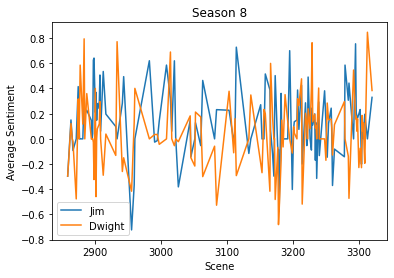

Correlation: 0.05180293865377079


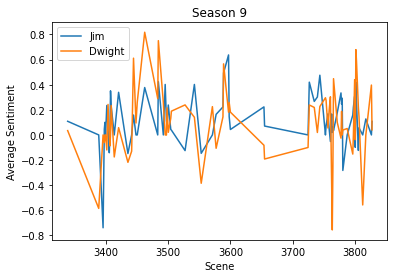

Correlation: 0.3236237589651327


In [20]:
# Take a look at data by season
for i in np.arange(1,10):
  season = together2.loc[together2['season'] == i]
  plt.plot(season['sc_total'], season['jim'], label ='Jim')
  plt.plot(season['sc_total'], season['dwight'], label = 'Dwight')
  plt.xlabel('Scene')
  plt.ylabel('Average Sentiment')
  plt.title('Season %i' %i)
  plt.legend()
  plt.show()
  print('Correlation:', season['jim'].corr(season['dwight']))

In [21]:
#let's look at where they had the biggest difference:
display(together2.sort_values('difference', ascending = False).head(10))


,sc_total,season,episode,jim,dwight,difference
417,2558,7,5,0.84810,-0.401900,1.250000
338,2126,6,7,0.67050,-0.510600,1.181100
438,2664,7,11,0.74240,-0.341200,1.083600
187,1281,4,4,0.53460,-0.521600,1.056200
211,1382,4,8,0.30620,-0.724800,1.031000
536,3114,8,13,0.72820,-0.291700,1.019900
429,2632,7,10,0.27770,-0.726900,1.004600
548,3173,8,15,0.50230,-0.481233,0.983533
497,2898,8,3,0.64165,-0.323350,0.965000
16,72,1,4,0.60580,-0.340900,0.946700


**Description of episodes in above list**

season 7 episode 5 : 'The Sting'
- Michael, Jim, and Dwight run a scam to discover why a competing salesman from a smaller rival company in Throop is so successful.

season 6 episode 7: 'Koi Pond'
- Michael falls into a koi pond during a sales visit, prompting a slew of mockery in the office. Elsewhere, Pam and Andy make cold calls, where they're constantly mistaken for a couple.

season 7 episode 11: 'Classy Christmas'
- Holly returns to fill in during Toby's jury duty, so Michael makes Pam throw a second office Christmas party to coincide with her return. Elsewhere, Jim accepts Dwight's challenge to a snowball fight, and Darryl anticipates Christmas with his daughter.

season 4 episode 4: Money
- As Jan renovates the condo, Michael confronts his growing debt every way he can, which includes pressuring his employees for a loan. Pam and Jim spend a night out on Dwight's family beet farm, now a bed and breakfast.

season 4 episode 8: The Deposition
- Jan sues Dunder Mifflin, and Michael is deposed as a witness; Kelly trash-talks Pam after Darryl beats Jim at pingpong

season 8 episode 13: Jury Duty
- When Jim returns from jury duty Dwight questions him about the case; Angela and the senator welcome their new baby.

season 7 episode 10: China
- Hearing of China's surging as an economic superpower convinces Michael that America desperately needs a new idea to keep pace. Elsewhere, Dwight's cutbacks in the building lead to Pam suggesting it might be time for Dunder Mifflin to move, and Darryl is annoyed with Andy's inane texts.

season 8 episode 15: Tallhassee
- In Tallahassee, Fla., Dwight tries to impress Sabre's special projects president; Andy tries to avoid requests for raises.

season 1 episode 4: The Alliance
- Michael tries to raise employee morale with a birthday party amid rumours of downsizing. 


**Conclusion**

No apparent correlation - positive or negative - between the two characters. As I looked through the episodes where their scores differed the most (list of top 10 above), some would appear to support the argument that a larger difference signifies more contention between the two rivals.  For instance,'Classy Christmas' is the episode where Jim & Dwight's infamous snowball fight takes place, and 'The Alliance' in season 1 is where we bear witness to one of the first pranks Jim pulls on Dwight by pretending to form an alliance with him to protect themselves from downsizing. 

On the other hand, if we look at the 'Tallahassee' episode in season 8, there is some back and forth between the characters, but no major event or conflict that any fan of the show would necessarily recall, especially considering all the other moments shared between them throughout the show's 9 seasons. 

Another episode that stands out is 'Money' in season 4 - this is when Jim & Pam stay at Dwight's beet farm for a night. In this episode, Jim & Dwight actually get along better than usual. We see a rare moment of friendship between the two as Jim comforts a hearbroken Dwight. 

Considering the fact that these episodes all appeared in the top 10, there doesn't seem to be any consistency between the difference in the characters' sentiments and the actual status of their relationship. 

As a longtime fan of the office and witness to the contentious relationship between Jim and Dwight throughout the show, I was expecting to see some sort of relation between their sentiment scores - While the data did not support this hypothesis, this could have been for a number of different reasons ( methodology of nltk Sentiment Analyzer, my choices in slicing and manipulating the data, the quality of the source data, etc.).
Perhaps instead of analyzing the sentiment of the words spoken, there could have been another metric I could have used instead to measure the human relationship between them, or maybe a different way to look at the data which would have yielded a stronger conclusion one way or the other.

